In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
import time
from sklearn.linear_model import LinearRegression
import pair_strategy
import alphavantage_call

In [35]:
### Set parameters of strategy to backtest ### 

code1 = 'SPLG'
code2 = 'IVV'
start_date = "2020-01-01"

# Alphavantage specific
api = "TIME_SERIES_DAILY"
API_KEY = "WICKC46DNNW922Q4"

# Methodology used and params
methodology = pair_strategy.bollinger_linear
params = {"entry": 1.5,
        "exit": 0.5,
        "lookback": 100}

# Average/approximate bid-ask spread on securities
spread = 0

In [27]:
timeseries1 = alphavantage_call.get_timeseries(API_KEY, api, code1)[pd.to_datetime(start_date):]
timeseries2 = alphavantage_call.get_timeseries(API_KEY, api, code2)[pd.to_datetime(start_date):]

In [28]:
### Split adjust timeseries ###

code_to_split_dates = alphavantage_call.obtain_split_dates(API_KEY, pd.Series([code1,code2]))

def split_adjust(timeseries, code):
    for date in code_to_split_dates[code].keys():
        if date in timeseries.index:
            timeseries[date:] = timeseries[date:] * code_to_split_dates[code][date]
    return timeseries

timeseries1 = split_adjust(timeseries1, code1).sort_index()
timeseries2 = split_adjust(timeseries2, code2).sort_index()

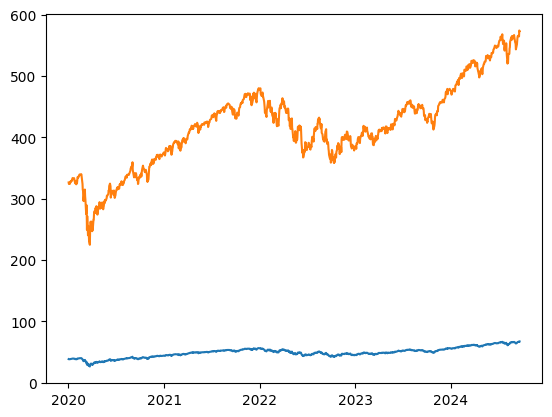

In [29]:
### Limit analysis to intersection of the two timeseries. Then, plot them ###
indices = timeseries1.index.intersection(timeseries2.index)
plt.plot(timeseries1[indices])
plt.plot(timeseries2[indices])

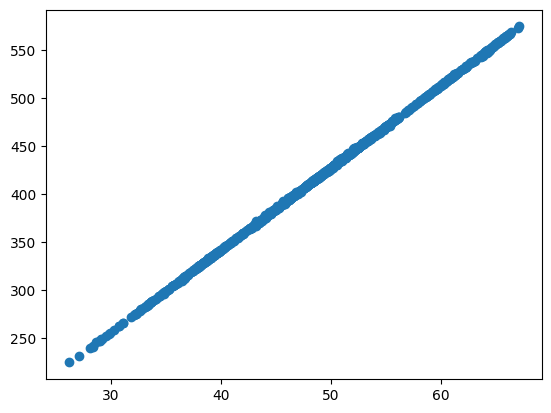

In [30]:
### Plot the relationship between the two ###
plt.scatter(timeseries1.loc[indices], timeseries2.loc[indices])

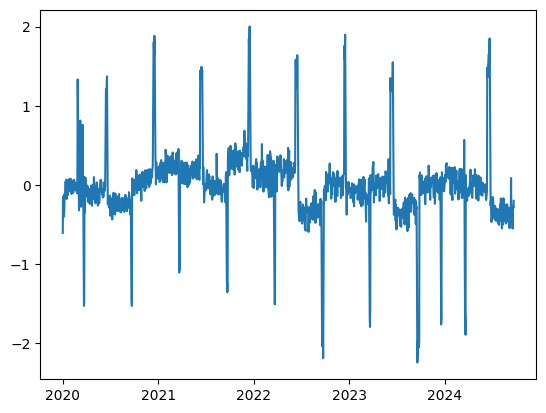

In [31]:
### Create and fit a linear regression. Visualize the deviation from the regression over time ###
model = LinearRegression()

# Fit the model
model.fit(timeseries1.loc[indices].to_frame(), timeseries2.loc[indices])

plt.plot(model.coef_[0]*timeseries1[indices] - timeseries2[indices] + model.intercept_)

In [33]:
### Optionally, recalculate lookback as 2x halflife of mean reversion
def calculate_half_life(tseries):
    model = LinearRegression()    
    dv = tseries.shift(1).dropna() 
    dv = dv - tseries[dv.index]
    lam = model.fit(tseries[dv.index].to_frame(), dv).coef_[0]
    print(lam)
    return -np.log(2)/lam

params["lookback"] = round(2*calculate_half_life(model.coef_[0]*timeseries1[indices] - timeseries2[indices] + model.intercept_))
print(params["lookback"])

-0.24468487788570012
6


In [36]:
import importlib
importlib.reload(pair_strategy)
positions1 = [0]
positions2 = [0]

# not very pandas-optimal. Oh well.
for i in indices[params["lookback"]:]:
    positions = methodology(timeseries1.loc[indices][:i], timeseries2.loc[indices][:i], positions1[-1], positions2[-1], **params)
    positions1.append(positions[0])
    positions2.append(positions[1])

positions1 = pd.Series(positions1, index=(indices[params["lookback"]:].append(pd.DatetimeIndex([pd.Timestamp.today().normalize()])))).iloc[:-1]
positions2 = pd.Series(positions2, index=(indices[params["lookback"]:].append(pd.DatetimeIndex([pd.Timestamp.today().normalize()])))).iloc[:-1]

In [40]:
positions1_lagged = timeseries1.shift(1)
positions2_lagged = positions2.shift(1)

prices1_adjusted = timeseries1.loc[positions1.index] * (1 - spread * np.sign(positions1))  # Subtract for long, add for short
prices2_adjusted = timeseries2.loc[positions2.index] * (1 - spread * np.sign(positions2))  # Subtract for long, add for short

pnl_1 = positions1 * (prices1_adjusted - prices1_adjusted.shift(1)) / prices1_adjusted
pnl_2 = positions2 * (prices2_adjusted - prices2_adjusted.shift(1)) / prices2_adjusted

2020-05-27         NaN
2020-05-28   -0.000000
2020-05-29    0.000000
2020-06-01    0.000000
2020-06-02    0.000000
2020-06-03    0.000000
2020-06-04   -0.000000
2020-06-05    0.000000
2020-06-08    0.000000
2020-06-09   -0.000000
2020-06-10   -0.000000
2020-06-11   -0.000000
2020-06-12    0.000000
2020-06-15    0.000000
2020-06-16   -0.160113
2020-06-17    0.039631
2020-06-18   -0.009315
2020-06-19    0.049185
2020-06-22   -0.016364
2020-06-23    0.000000
2020-06-24   -0.000000
2020-06-25    0.000000
2020-06-26   -0.000000
2020-06-29    0.000000
2020-06-30    0.000000
2020-07-01    0.000000
2020-07-02    0.000000
2020-07-06    0.000000
2020-07-07   -0.000000
2020-07-08    0.000000
2020-07-09   -0.000000
2020-07-10    0.000000
2020-07-13   -0.000000
2020-07-14    0.000000
2020-07-15    0.000000
2020-07-16   -0.000000
2020-07-17    0.000000
2020-07-20    0.000000
2020-07-21    0.000000
2020-07-22    0.000000
2020-07-23   -0.000000
2020-07-24   -0.000000
2020-07-27    0.000000
2020-07-28 

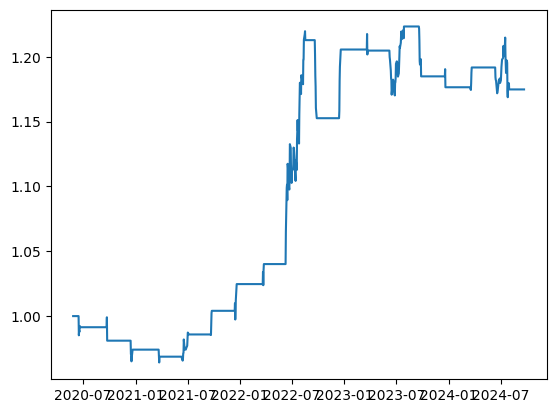

In [41]:
print(pnl_1.to_string())
print(pnl_2.to_string())

gross_market_value = positions1.abs() + positions2.abs()
#print(gross_market_value)
ret = ((pnl_1 + pnl_2) / gross_market_value).fillna(0)
ret = np.cumprod(1 + ret)
#ret.fillna(0, inplace=True)
plt.plot(ret)